## Importing the pywavan functions and the required liberaries

In [76]:
%pylab inline
from pywavan import fbm2d
from pywavan import powspec
from pywavan import imsmooth
from pywavan import fan_trans
from pywavan import tauq
from pywavan import Dh
from pywavan import angluarPS
import itertools
from scipy.stats import linregress
from scipy import interpolate
from random import randint
from random import sample 
from scipy.interpolate import griddata

Populating the interactive namespace from numpy and matplotlib


## Generating the normally-distributed image

In [77]:
#Create a nx X ny pixels map with a power law gamma
nx = 512
ny = 512
gamma = -3

fbm= fbm2d(gamma, ny,nx)
wt, S11a, wav_k, S1a, q = fan_trans(fbm, zeromean=False, reso=1, q=0, qdyn=False, angular=True)

Text(0.5, 1.0, 'Reconstructued fBm')

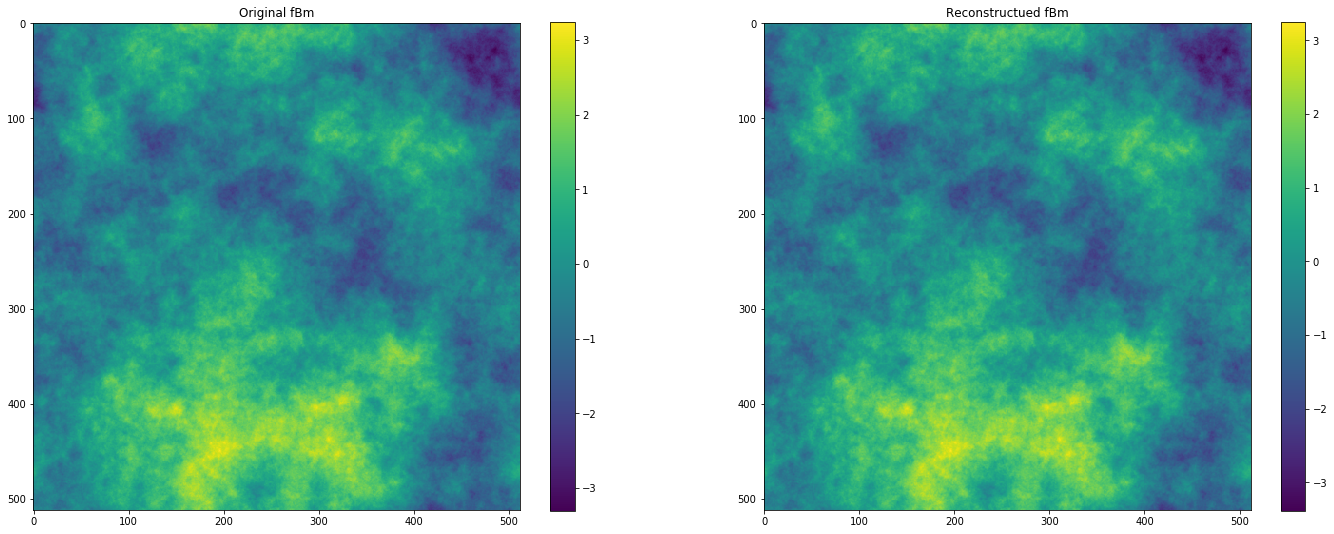

In [78]:
#Reconstructing the fBm after using fan_trans by summing over the angles (j) and the scales (i)

fBm=np.zeros((ny,nx)) #The reconstructed fBm

fBm=np.sum(wt.real,axis=0) #Summing over the angles
fBm=np.sum(fBm,axis=0) #Summing over the scales

figure(figsize=(24,9))
plt.subplot(1,2,1)
imshow(fbm)
colorbar()
plt.title('Original fBm')
plt.subplot(1,2,2)
imshow(fBm)
colorbar()
plt.title('Reconstructued fBm')

Text(0.5, 1.0, 'Multiplicative model')

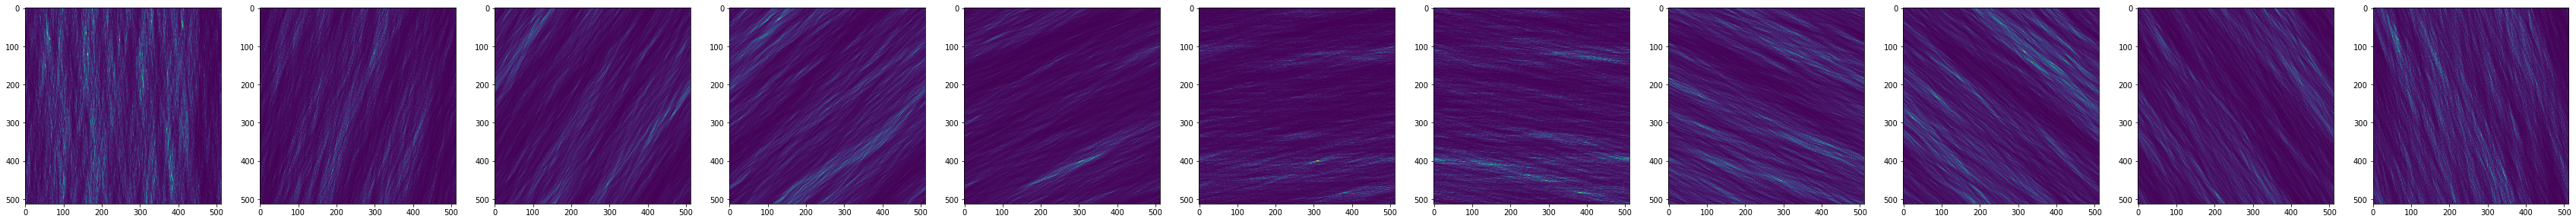

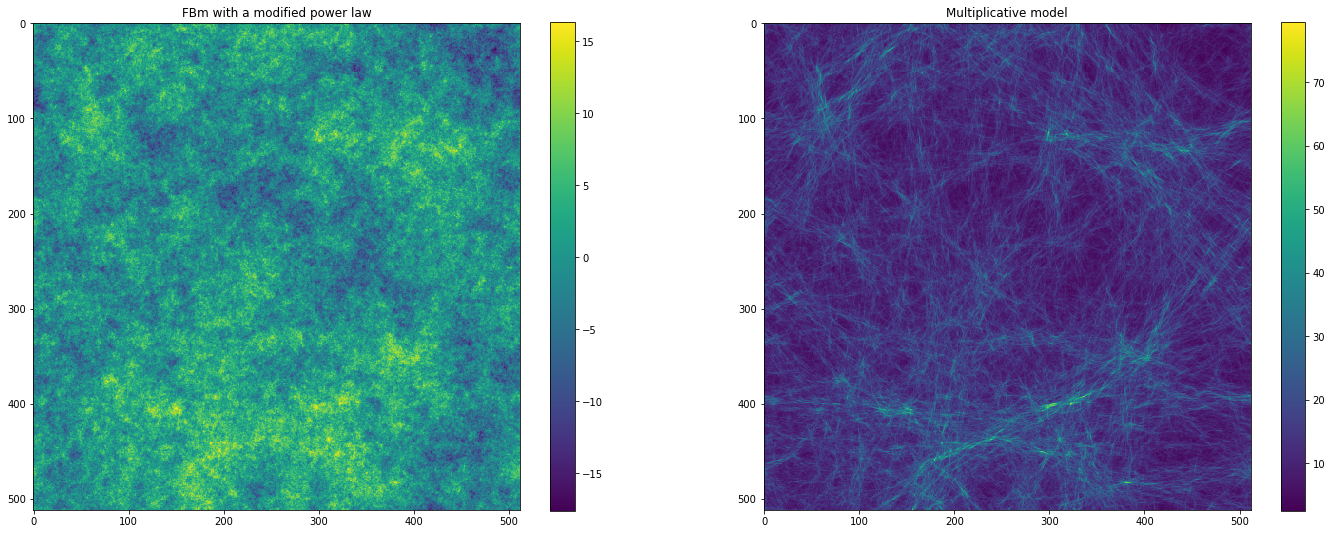

In [79]:
#Constructing the filamentary multiplicative model by multiplying the scales (i) and adding over the angles (j)
#The standard deviation of the scales is changed to std_G then it is exponentiated to force a log-normal distribution before the multiplication

N=wt.shape[1] #Number of angles
M=wt.shape[0] #number of scales
std_G=0.1 #The standard deviation of the Gaussian images (before the exponential), this parameter control the difference between the G and the NG slopes. typical value is 0.1

mpv=np.zeros((ny,nx)) #The multiplicative model
mpv_ang=np.zeros((N,ny,nx)) #The anglular components of the multiplicative model
fbm_ang=np.zeros((N,ny,nx)) #The anglular components of the fbm model after changing the power law

for j in range(N): #Looping over angles
    
    for i in range(M): #looping over scales
        
        t=wt[i,j,:,:].real #A temporary varible used to do operations on the subimage
        t=t/np.std(t)
        
        fbm_ang[j,:,:]=fbm_ang[j,:,:]+t
        
    fbm_ang[j,:,:]=fbm_ang[j,:,:]*std_G
    mpv_ang[j,:,:]=np.exp(fbm_ang[j,:,:])


mpv=np.sum(mpv_ang,axis=0) #Adding over angles to create
fbm_mpl=np.sum(fbm_ang,axis=0) #A fBm with a new modified power law

#Ploting the anglular components of the multiplicative model
figure(figsize=(60,9))
for j in range(N):
    plt.subplot(1,N,j+1)
    imshow(mpv_ang[j,:,:])

figure(figsize=(24,9))
plt.subplot(1,2,1)
imshow(fbm_mpl)
colorbar()
plt.title('FBm with a modified power law')
plt.subplot(1,2,2)
imshow(mpv)
colorbar()
plt.title('Multiplicative model')

In [80]:
#Calculate the power spectrum of the multiplicative model for the Gaussian and the non-Gaussian parts (q)
tab_k, spec_k_mpv= powspec(mpv, reso=1.)

q=[]
q=[2.9]*M
wt_mpv, S11a, wav_k, S1a_mpv, q = fan_trans(mpv, zeromean=False, reso=1, q=q, qdyn=True, skewl=0.4)
#Flattening the mpv. to plot the histogram
hist_mpv = list(itertools.chain.from_iterable(mpv))

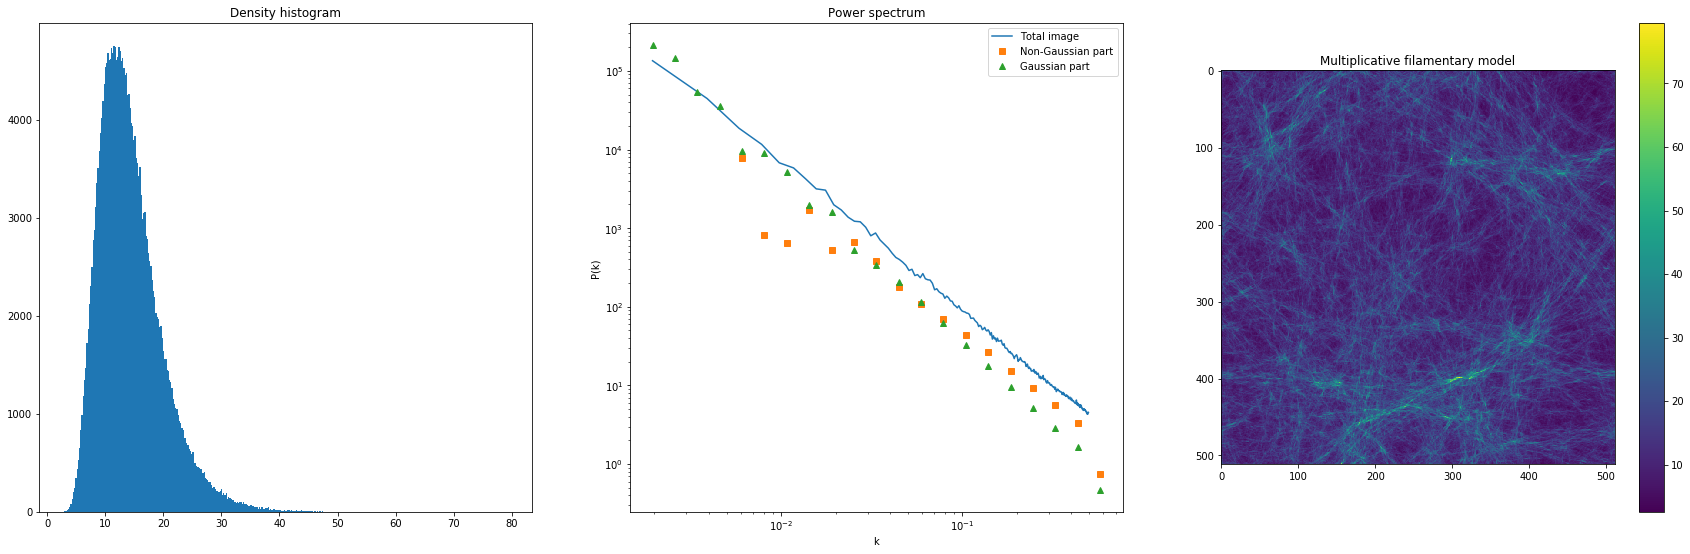

In [81]:
#Plotting
figure(figsize=(30,9))
plt.subplot(1,3,1)
plt.hist(hist_mpv,bins='auto', label='Multiplicative filamentary model')
plt.title('Density histogram')
plt.subplot(1,3,2)
plot(tab_k, spec_k_mpv, label='Total image')
plot(wav_k, S1a_mpv[1,:], 's', label='Non-Gaussian part')
plot(wav_k, S1a_mpv[2,:], '^', label='Gaussian part')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k')
plt.ylabel('P(k)')
plt.legend()
plt.title('Power spectrum')
plt.subplot(1,3,3)
imshow(mpv)
colorbar()
plt.title('Multiplicative filamentary model')
plt.show()


Text(0.5, 1.0, 'Homogeneous part (G)')

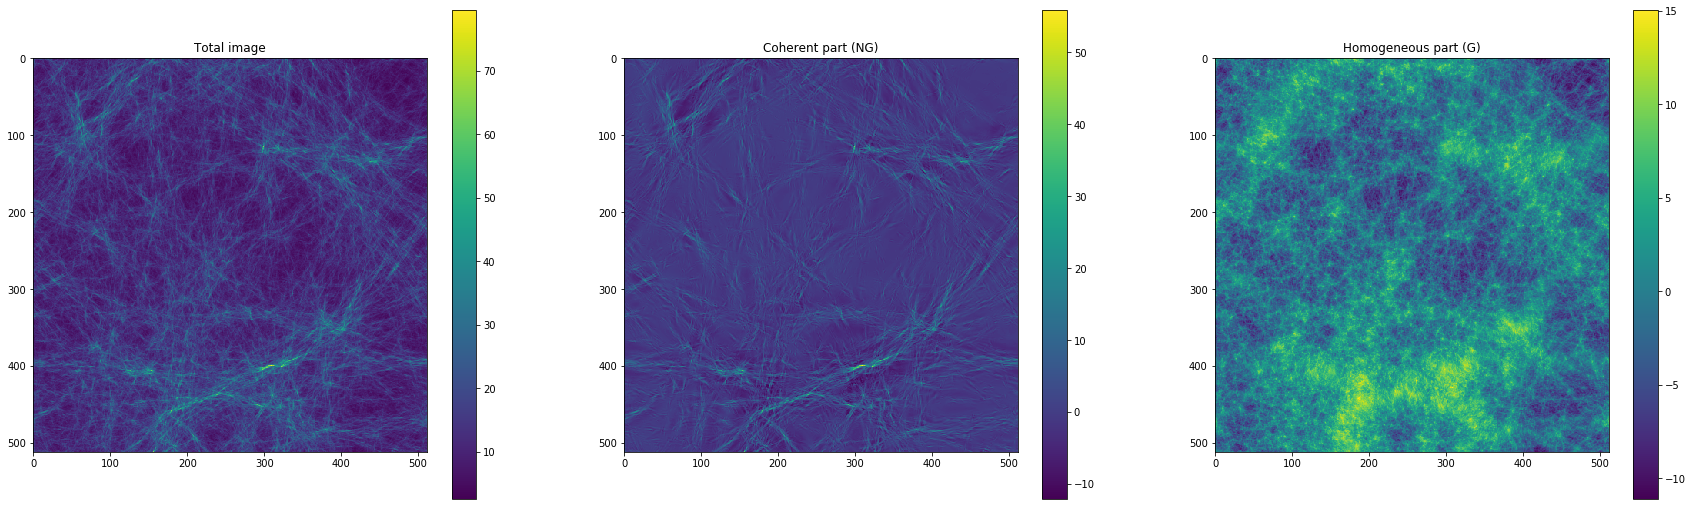

In [82]:
#Constructing and plotting the G and NG parts of the mpv. model by looping over the scales.
#wt_mpv has the scales of the G and NG parts, for more information see the help of fan_trans.

mpv_G=np.zeros((ny,nx)) #Gaussian part
mpv_NG=np.zeros((ny,nx)) #Non-Gaussian part

for i in range(M): #looping over the scales.
    mpv_G=mpv_G+wt_mpv[i+2*M,:,:].real
    mpv_NG=mpv_NG+wt_mpv[i+M,:,:].real


figure(figsize=(30,9))
plt.subplot(1,3,1)
imshow(mpv)
colorbar()
plt.title('Total image')
plt.subplot(1,3,2)
imshow(mpv_NG)
colorbar()
plt.title('Coherent part (NG)')
plt.subplot(1,3,3)
imshow(mpv_G)
colorbar()
plt.title('Homogeneous part (G)')

# Inversion algorithm

The inversion process is done using MnGSeg technique (fan_trans function). After using fan_trans to separate the scales and the angles, the image of each angle is reconstructed separately by adding all the scales then using the log() function the multiplicative process become an addition process

$$log(\Pi_i e^{k_i})=\Sigma_i k_i$$

Finally, using the fant_trans function the scales $k_i$ or $e^{k_i}$ that construct the multiplicative process can be revealed.

In [83]:
#Seprating the scales and the angles.
wt_mpv, S11a, wav_k, S1a, q = fan_trans(mpv, reso=1, zeromean=False, q=0 , qdyn=True, skewl=0.4, pownorm=False, angular=True)

In [99]:
wt_mpv_inv=np.zeros((M,N,ny,nx),dtype=numpy.complex) 

mpv_ang_inv=np.zeros((N,ny,nx)) #The anglular components of the inverse mpv. image

fbm_ang_inv=np.zeros((N,ny,nx)) #The anglular components of the inverse fbm. image

l=np.zeros((N,ny,nx),dtype=numpy.bool) #Logical matrix to check for the nan values of log(mpv_ang_inv[j,:,:])

t=np.zeros((ny,nx)) #A temp to set the nan values to zero 

for j in range(N):
    
    mpv_ang_inv[j,:,:]=np.sum(wt_mpv[:,j,:,:].real,axis=0) #The mpv. image for this specific angle
    
    #--------------------------------------------------------------#
    mpv_ang_inv[j,:,:]=mpv_ang_inv[j,:,:]+np.mean(mpv_ang[j,:,:])  # #######  Restoring the original mean #########
    #--------------------------------------------------------------#
    
    mpv_ang_inv[j,:,:]=mpv_ang_inv[j,:,:]/np.std(mpv_ang_inv[j,:,:])*np.std(mpv_ang[j,:,:])
    
    fbm_ang_inv[j,:,:]=log(mpv_ang_inv[j,:,:]) #The fbm. image for this specific angle
    #fbm_ang_inv[j,:,:]=log(mpv_ang[j,:,:]) #This is a test. Delet it.
    
    l[j,:,:]=numpy.isnan(fbm_ang_inv[j,:,:])
    t[:,:]=fbm_ang_inv[j,:,:] 
    t[l[j,:,:]]=0
    
    #fbm_ang_inv[j,:,:]=fbm_ang_inv[j,:,:]/np.std(fbm_ang_inv[j,:,:])*np.std(fbm_ang[j,:,:])
    
    wt_mpv_inv[:,j,:,:], S11a, wav_k, S1a, q = fan_trans(t, zeromean=False, reso=1, q=0 , qdyn=True, skewl=0.4, pownorm=False)    
    

/nix/store/c1vk9xd7sixznbayzaxlbr2dg0v7j4y4-python3.6-ipykernel-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log


The separation of the angular components of the multiplicative model using the fan_trans function is not perfect. The mean value of the image of each angle is zero and the original distribution of mean values is lost. This is corrected by adding the **know** mean values of the **multiplicative model**, but these mean values will not be known for observations. Without the right distribution of the mean values the reconstructed image is filamentary and does not look like the original fbm. 

Another problem is the left tail in the histogram of the image of each angle of the multiplicative model. This tail doesn't exist in the original images of the angular multiplicative model components. Unlike the original images that doesn not have negative values, this tail causes the separated images to have. As a result of applying the log function on these negative values the reconstructed images of the fbm angular components have **nan** values. As a correction, these nan values is set to be equal to zero.    

In [98]:
#This cell removes the results of the previous cell.
#Instead of allowing the negative values in mpv_ang_inv which results in nan values in fbm_ang_inv, I try to remove these negative values and interpolate from the know non-negative values.

wt_mpv_inv=np.zeros((M,N,ny,nx),dtype=numpy.complex) 

mpv_ang_inv=np.zeros((N,ny,nx)) #The anglular components of the inverse mpv. image

fbm_ang_inv=np.zeros((N,ny,nx)) #The anglular components of the inverse fbm. image

l=np.zeros((N,ny,nx),dtype=numpy.bool) #Logical matrix to check for the nan values of log(mpv_ang_inv[j,:,:])

t=np.zeros((ny,nx)) #A temp to set the nan values to zero 

grid_x, grid_y = np.mgrid[0:511:512j, 0:511:512j]

for j in range(1):
    
    mpv_ang_inv[j,:,:]=np.sum(wt_mpv[:,j,:,:].real,axis=0) #The mpv. image for this specific angle
    
    #--------------------------------------------------------------#
    mpv_ang_inv[j,:,:]=mpv_ang_inv[j,:,:]-np.mean(mpv_ang_inv[j,:,:])+np.mean(mpv_ang[j,:,:])  # #######  Restoring the original mean #########
    #--------------------------------------------------------------#
    
    mpv_ang_inv[j,:,:]=mpv_ang_inv[j,:,:]/np.std(mpv_ang_inv[j,:,:])*np.std(mpv_ang[j,:,:])
    
    l[j,:,:]=(mpv_ang_inv[j,:,:]<=0)
    x=grid_x[~l[j,:,:]] #Points used to interpolate.
    y=grid_y[~l[j,:,:]] #Points used to interpolate.
    values=mpv_ang_inv[j,~l[j,:,:]]  #Values of the points used to interpolate. 
    
    temp=sample(range(0,np.size(x)),np.int(np.size(x)/10))
    x=x[temp]
    y=y[temp]
    values=values[temp]
    
    points=[x,y]
    points=np.transpose(points)
    
    mpv_ang_inv[j,:,:] = griddata(points, values, (grid_x, grid_y), method='nearest')
    
    fbm_ang_inv[j,:,:]=log(mpv_ang_inv[j,:,:]) #The fbm. image for this specific angle
    #fbm_ang_inv[j,:,:]=log(mpv_ang[j,:,:]) #This is a test. Delet it.
    
    
    #fbm_ang_inv[j,:,:]=fbm_ang_inv[j,:,:]/np.std(fbm_ang_inv[j,:,:])*np.std(fbm_ang[j,:,:])
    
    #wt_mpv_inv[:,j,:,:], S11a, wav_k, S1a, q = fan_trans(t, zeromean=False, reso=1, q=0 , qdyn=True, skewl=0.4, pownorm=False)    
    

In [ ]:
for j in range(N):
    
    '''
    mpv_ang_inv[j,:,:]=mpv_ang_inv[j,:,:]/np.std(mpv_ang_inv[j,:,:])
    mpv_ang[j,:,:]=mpv_ang[j,:,:]/np.std(mpv_ang[j,:,:])
    '''
    #mpv_ang_inv[j,:,:]=mpv_ang_inv[j,:,:]-np.mean(mpv_ang_inv[j,:,:])
    #mpv_ang[j,:,:]=mpv_ang[j,:,:]-np.mean(mpv_ang[j,:,:])
    
    hist_mpv_ang = list(itertools.chain.from_iterable(mpv_ang[j,:,:]))
    hist_mpv_ang_inv = list(itertools.chain.from_iterable(mpv_ang_inv[j,:,:]))
    
    hist_fbm_ang = list(itertools.chain.from_iterable(fbm_ang[j,:,:]))
    #hist_fbm_ang_inv = list(itertools.chain.from_iterable(fbm_ang_inv[j,:,:]))
    
    hist_fbm_ang_inv = fbm_ang_inv[j,~l[j,:,:]]
    
    
    figure(figsize=(36,12))
    plt.subplot(1,4,1)
    imshow(mpv_ang_inv[j,:,:])
    #plt.plot(points[:,0], points[:,1], 'k.', ms=1)
    colorbar()
    plt.title('Inversion process')
    plt.subplot(1,4,2)
    imshow(mpv_ang[j,:,:])
    colorbar()
    plt.title('Original fBm. model')
    plt.subplot(1,4,3)
    #plt.hist(hist_mpv_ang,bins='auto', label='Original mpv.model')
    plt.hist(hist_mpv_ang_inv,bins='auto', label='Inversion process')
    plt.hist(hist_mpv_ang,bins='auto', label='Original mpv.model')
    plt.legend()
    plt.title('Histogram of mpv. model')
    plt.subplot(1,4,4)
    plt.hist(hist_fbm_ang_inv,bins='auto', label='Inversion process')
    plt.hist(hist_fbm_ang,bins='auto', label='Original fbm.model')
    plt.legend()
    plt.title('Histogram of mpv. model')

Text(0.5, 1.0, 'Reconstructed fBm')

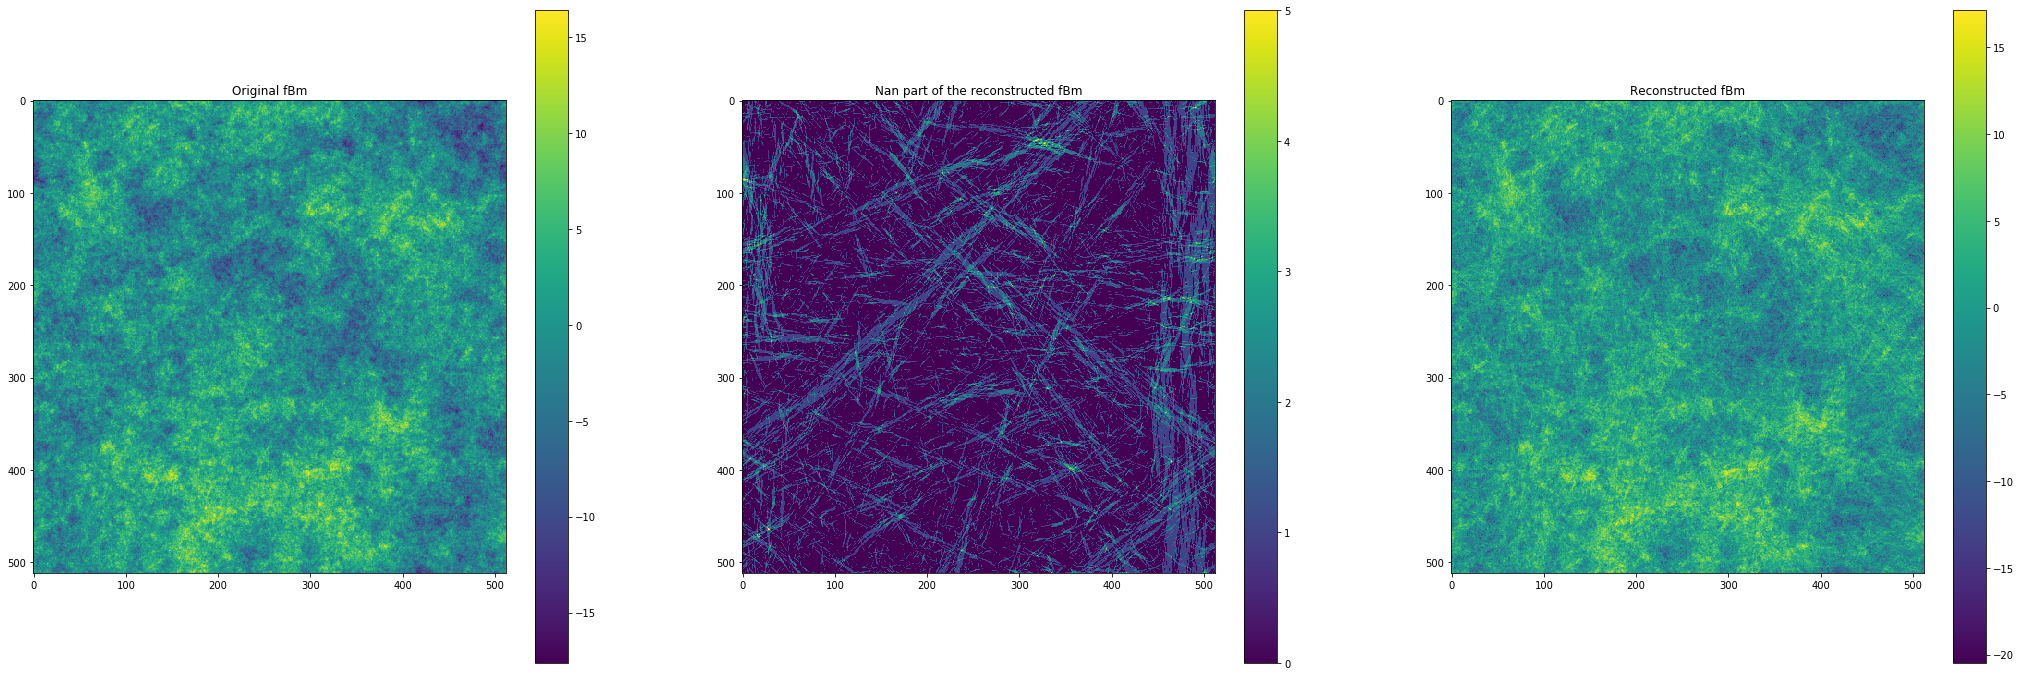

In [86]:
#Comparing the angular components of the original mpv. model and the inversion process.

fbm_ang_inv[l]=0
fbm_inv=np.sum(fbm_ang_inv,axis=0)
mpv_inv=np.sum(mpv_ang_inv,axis=0)
fbm_inv=fbm_inv/np.std(fbm_inv)*np.std(fbm_mpl)

#Calculating the removed part of the image (Nan part)
n=l*1
n=np.sum(n,axis=0)


figure(figsize=(36,12))
plt.subplot(1,3,1)
imshow(fbm_mpl)
colorbar()
plt.title('Original fBm')
plt.subplot(1,3,2)
imshow(n)
colorbar()
plt.title('Nan part of the reconstructed fBm')
plt.subplot(1,3,3)
imshow(fbm_inv)
colorbar()
plt.title('Reconstructed fBm')

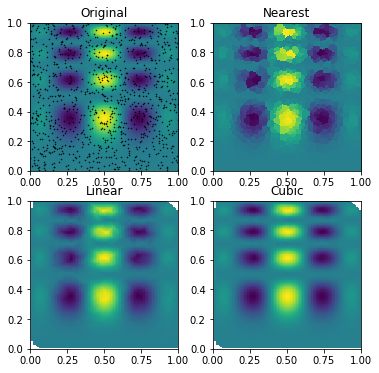

In [97]:
#Some test on interpolation
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

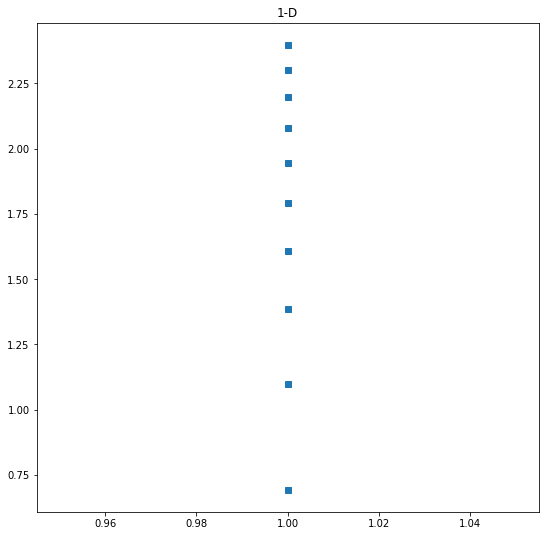

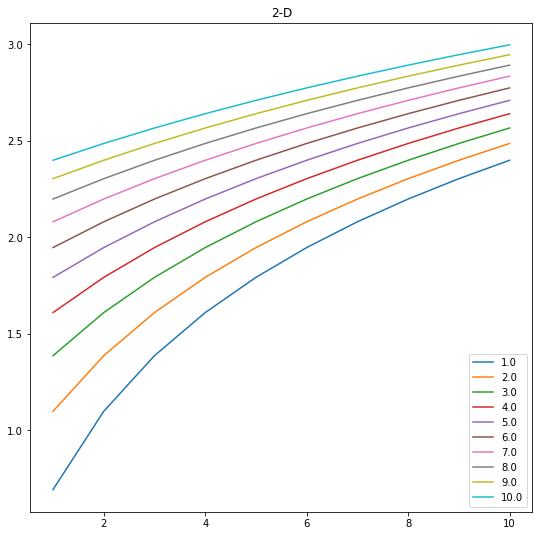

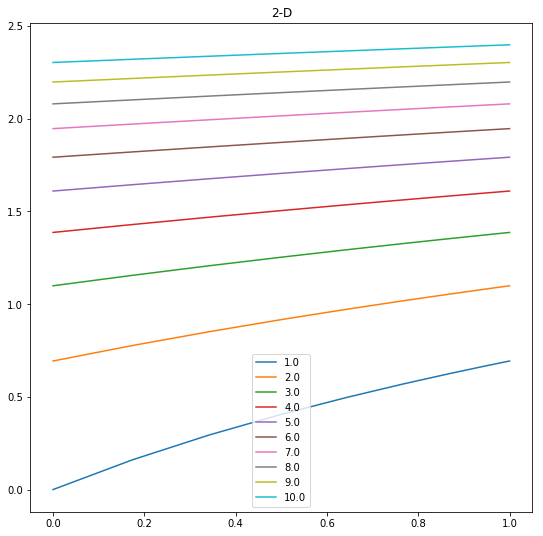

In [12]:
#Tests on the effect of the mean value on the log(a+b) step of the inversion process

#1-D

a=np.linspace(1,1,10)
b=np.linspace(1,10,10)
lo=log(a+b)

figure(figsize=(9,9))
plot(a,lo,'s')
plt.title('1-D')


#2-D
#linear structure

a=np.linspace(1,10,10)
b=np.linspace(1,10,10)

figure(figsize=(9,9))
for i in range(10):
    
    lo=log(a+b[i])
    plot(a,lo,label=b[i])
plt.title('2-D')
plt.legend()

#Sin. structure

a=np.linspace(0,np.pi/2,10)
a=np.sin(a)
b=np.linspace(1,10,10)

figure(figsize=(9,9))
for i in range(10):
    
    lo=log(a+b[i])
    plot(a,lo,label=b[i])
plt.title('2-D')
plt.legend()